## Table des matières
* [Nettoyage des jeux de données](#partie1)
    * [Erreur de formatage](#sous_partie1-1)
    * [Valeurs manquantes](#sous_partie1-2)
    * [Détection des outliers](#sous_partie1-3)
    * [Détection des doublons](#sous_partie1-4)
* [Jointure des tables](#partie2)
    * [Nettoyage de la jointure finale](#partie3)
    * [Remplissage du produit vide](#sous_partie3-1)
    * [Organisation des données](#sous_partie3-3)
* [Indicateurs de vente](#sous_partie4-1)
    * [Evolution mensuelle du chiffre d'affaires](#sous_partie4-1-3)
    * [Croissance du chiffre d'affaires](#sous_partie4-1-2)
    * [Chiffre d'affaires total](#sous_partie4-1-1)
    * [Baisse de chiffre d'affaires en octobre 2021](#sous_partie4-1-4)
    * [Prix moyen par catégorie](#sous_partie4-1-5)
    * [Références : tops et flops](#sous_partie4-1-6)
    * [Répartition des ventes par catégorie](#sous_partie4-1-8)
    * [Répartition du chiffre d'affaires par catégorie](#sous_partie4-1-9)
    * [Chiffre d'affaires annuel par catégorie](#sous_partie4-1-7)
* [Profils client](#sous_partie4-2) 
    * [Chiffre d'affaires par client](#sous_partie4-1-10)
    * [Lien entre l’âge et le montant total des achats](#sous_partie4-2-2)  
    * [Lien entre l’âge et la taille du panier moyen](#sous_partie4-2-4)
    * [Lien entre l’âge et la fréquence d'achat](#sous_partie4-2-3)     
    * [Lien entre l’âge et les catégories des livres achetés](#sous_partie4-2-5)
    * [Lien entre le genre et les catégories des livres achetés](#sous_partie4-2-1) 

# Synthèse des résultats

En 2022, le chiffre d’affaires de la boutique en ligne grimpe de 28 %, principalement en raison d’un pic de ventes en février-mars et d’une belle stabilité annuelle. Cependant, les ventes de la catégorie 1 ont connu une chute importante en octobre 2021 malgré un prix moyen de 20,49 euros. Les revenus du premier trimestre ont frôlé les 1 million d'euros, et l'année 2023 s'annonce encore meilleure. Les clients ont des profils différents, avec une parité entre les hommes et les femmes, mais l'âge est un facteur déterminant, avec les 35-44 ans en tête. La plupart des clients sont occasionnels.

# Importation des librairies

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from numpy.random import poisson
from scipy import stats
from scipy.stats import pearsonr, shapiro, f_oneway

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
plt.style.use('seaborn-darkgrid')

import datetime as dt
from datetime import date

### Constantes
today = date.today()
year = today.strftime("%Y")

# Exploration des données 

La base de données sur laquelle se base ce projet possède trois fichiers : "transactions", "products" et "customers".

Après exploration, les fichiers contiennent :

* 679 532 entrées regroupant les transactions des trois dernières années (mars 2021 à mars 2023),
* 3 287 produits renseignés sur 3 variables différentes ("id_prod", "price", "categ"),
* 8 623 clients renseignés sur 3 variables différentes ("client_id", "sex", "birth").


#### Dataset 1 : Transactions

Nous avons 679 532 transactions renseignées sur 4 variables différentes. 

In [2]:
transaction = pd.read_csv("transactions.csv")
display(transaction.head())

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [3]:
transaction.shape

(679532, 4)

#### Dataset 2 : Produits

Nous avons 3 287 produits renseignés sur 3 variables différentes. 

In [4]:
produit = pd.read_csv("products.csv")
display(produit.head())

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [5]:
produit.shape

(3287, 3)

#### Dataset 3 : Clients

Nous avons 8 623 clients renseignés sur 3 variables différentes.

In [6]:
client = pd.read_csv("customers.csv")
display(client.head())

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [7]:
client.shape

(8623, 3)

# Nettoyage des données<a class="anchor" id="partie1"></a>

Le nettoyage des données se fait au cours de 4 étapes.

## 1.1 Erreur de formatage<a class="anchor" id="sous_partie1-1"></a>

Un examen rapide montre qu'il existe deux variables dont les formats sont incorrectes :

* La variable "date" dans le fichier des transactions.
* La variable "categ" dans le fichier des produits.

Ces deux erreurs nécessitent un traitement adéquat.

#### Traitement des dates

In [8]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


Pour traiter les dates, nous devons d'abord supprimer les strings qui empêchent la conversion. 200 lignes sont retirées du dataset.

In [9]:
transaction = transaction.loc[~transaction["date"].str.contains("test_2021")]
print('Shape:', transaction.shape)

Shape: (679332, 4)


Par soucis de lisibilité, nous allons déplacer l'heure de la transaction dans une nouvelle colonne.

In [10]:
transaction["split_date"] = transaction["date"].str.split(pat=" ")
transaction["time"] = transaction["split_date"].str.get(1)
transaction["date"] = transaction["split_date"].str.get(0)
transaction = transaction.drop(["split_date"], axis=1)

transaction = transaction[["id_prod", "date", "time", "session_id", "client_id"]]
display(transaction.head())

,id_prod,date,time,session_id,client_id
0,0_1518,2022-05-20,13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02,07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18,15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24,04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11,08:22:08.194479,s_325227,c_4232


Nous pouvons désormais convertir la variable "date" en datetime.

In [11]:
transaction["date"] = pd.to_datetime(transaction["date"])
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   time        679332 non-null  object        
 3   session_id  679332 non-null  object        
 4   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 31.1+ MB


#### Traitement des catégories

In [12]:
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


Cette variable a été détectée comme un integer. Elle est en faite une variable qualitative dichotomique. Nous la transformons donc en string.

In [13]:
produit["categ"] = produit["categ"].astype(str)
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   object 
dtypes: float64(1), object(2)
memory usage: 77.2+ KB


## 1.2 Valeurs manquantes<a class="anchor" id="sous_partie1-2"></a>

Aucune valeur manquantes dans les trois fichiers.

#### Dataset 1 : Transactions

In [14]:
transaction.isnull().sum()

id_prod       0
date          0
time          0
session_id    0
client_id     0
dtype: int64

#### Dataset 2 : Produits

In [15]:
produit.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

#### Dataset 3 : Clients

In [16]:
client.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

## 1.3 Détection des outliers<a class="anchor" id="sous_partie1-3"></a>

Les datasets "transactions" et "clients ne contiennent aucun outlier. Par contre, le dataset "produits" semblent afficher un prix en dessous de 0 euros. Compte tenu de l’importance de cette variable, nous transformons cette valeur.

#### Traitement des prix negatifs

In [17]:
produit.describe()

,price
count,3287.000000
mean,21.856641
std,29.847908
min,-1.000000
25%,6.990000
50%,13.060000
75%,22.990000
max,300.000000


Nous isolons les produits pouvant contenir des prix en dessous de 0 euros.

In [18]:
neg_produit = produit.loc[produit["price"] < 0]
produit.iloc[[731], [1]] = 0
display(produit.iloc[731:732])

,id_prod,price,categ
731,T_0,0.0,0


## 1.4 Détection des doublons<a class="anchor" id="sous_partie1-4"></a>

Aucun doublon n'a été repéré dans les trois fichiers.

#### Dataset 1 : Transactions

In [19]:
transaction[transaction.duplicated(keep="last")]

,id_prod,date,time,session_id,client_id


#### Dataset 2  : Produits

In [20]:
produit[produit.duplicated(keep="last")]

,id_prod,price,categ


#### Dataset 3  : Clients

In [21]:
client[client.duplicated(keep="last")]

,client_id,sex,birth


# Jointure des tables<a class="anchor" id="partie2"></a>

Pour préparer la jointure, nous resettons les index des trois datasets.

#### Dataset 1 : Transactions

In [22]:
transaction.reset_index(drop=True)
display(transaction.head())

,id_prod,date,time,session_id,client_id
0,0_1518,2022-05-20,13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02,07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18,15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24,04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11,08:22:08.194479,s_325227,c_4232


#### Dataset 2 : Produits

In [23]:
produit.reset_index(drop=True)
display(produit.head())

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


#### Dataset 3 : Clients

In [24]:
client.reset_index(drop=True)
display(client.head())

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


Nous effectuons d'abord une jointure à gauche de la dataset "transactions" avec la dataset "produits". On obtient comme résultat toutes les transactions avec les produits correspondants. 

In [25]:
df_produit = pd.merge(transaction, produit, how="left", on="id_prod", indicator=True)
display(df_produit.head())

,id_prod,date,time,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20,13:21:29.043970,s_211425,c_103,4.18,0,both
1,1_251,2022-02-02,07:55:19.149409,s_158752,c_8534,15.99,1,both
2,0_1277,2022-06-18,15:44:33.155329,s_225667,c_6714,7.99,0,both
3,2_209,2021-06-24,04:19:29.835891,s_52962,c_6941,69.99,2,both
4,0_1509,2023-01-11,08:22:08.194479,s_325227,c_4232,4.99,0,both


211 transactions ne sont pas liées à des informations produit. Il semblerait être associé à un seul produit.

In [26]:
print(df_produit[df_produit["_merge"] != "both"])

       id_prod       date             time session_id client_id  price categ  \
2633    0_2245 2022-09-23  07:22:38.636773   s_272266    c_4746    NaN   NaN   
10103   0_2245 2022-07-23  09:24:14.133889   s_242482    c_6713    NaN   NaN   
11723   0_2245 2022-12-03  03:26:35.696673   s_306338    c_5108    NaN   NaN   
15670   0_2245 2021-08-16  11:33:25.481411    s_76493    c_1391    NaN   NaN   
16372   0_2245 2022-07-16  05:53:01.627491   s_239078    c_7954    NaN   NaN   
...        ...        ...              ...        ...       ...    ...   ...   
669533  0_2245 2021-08-25  09:06:03.504061    s_80395     c_131    NaN   NaN   
670484  0_2245 2022-03-06  19:59:19.462288   s_175311    c_4167    NaN   NaN   
671088  0_2245 2022-05-16  11:35:20.319501   s_209381    c_4453    NaN   NaN   
675480  0_2245 2022-02-11  09:05:43.952857   s_163405    c_1098    NaN   NaN   
677797  0_2245 2021-12-14  22:34:54.589921   s_134446    c_4854    NaN   NaN   

           _merge  
2633    left_only  

In [27]:
df_produit = df_produit.drop("_merge", axis=1)

Nous joignons ensuite ce nouveau dataset avec le dataset "clients". On obtient comme résultat toutes les lignes du nouveau dataset avec les clients correspondants.

In [28]:
df_lapage = pd.merge(df_produit, client, how="right", on="client_id", indicator=True)
display(df_lapage.head())

,id_prod,date,time,session_id,client_id,price,categ,sex,birth,_merge
0,0_1316,2021-12-29,09:11:18.860592,s_141762,c_4410,7.20,0,f,1967,both
1,1_385,2021-03-22,01:40:22.782925,s_9707,c_4410,25.99,1,f,1967,both
2,1_190,2021-11-12,18:11:43.280574,s_118628,c_4410,14.53,1,f,1967,both
3,0_1455,2021-03-22,14:29:25.189266,s_9942,c_4410,8.99,0,f,1967,both
4,1_483,2022-03-13,21:35:55.949042,s_178686,c_4410,15.99,1,f,1967,both


Certains clients ne sont pas liés à des transactions. On peut imaginer que ce sont des comptes qui n'ont jamais effectué d'achats. Ils ne sont pas actifs.

In [29]:
print(df_lapage[df_lapage["_merge"] != "both"])

       id_prod date time session_id client_id  price categ sex  birth  \
59493      NaN  NaT  NaN        NaN    c_8253    NaN   NaN   f   2001   
200286     NaN  NaT  NaN        NaN    c_3789    NaN   NaN   f   1997   
218173     NaN  NaT  NaN        NaN    c_4406    NaN   NaN   f   1998   
218174     NaN  NaT  NaN        NaN      ct_0    NaN   NaN   f   2001   
220389     NaN  NaT  NaN        NaN    c_2706    NaN   NaN   f   1967   
225539     NaN  NaT  NaN        NaN    c_3443    NaN   NaN   m   1959   
248410     NaN  NaT  NaN        NaN    c_4447    NaN   NaN   m   1956   
248966     NaN  NaT  NaN        NaN    c_3017    NaN   NaN   f   1992   
261025     NaN  NaT  NaN        NaN    c_4086    NaN   NaN   f   1992   
313134     NaN  NaT  NaN        NaN    c_6930    NaN   NaN   m   2004   
319728     NaN  NaT  NaN        NaN    c_4358    NaN   NaN   m   1999   
387401     NaN  NaT  NaN        NaN    c_8381    NaN   NaN   f   1965   
392685     NaN  NaT  NaN        NaN    c_1223    Na

In [30]:
df_lapage = df_lapage.drop("_merge", axis=1)

## 1.1 Nettoyage de la jointure finale<a class="anchor" id="partie3"></a>

23 clients n'ont pas effectués de transactions.

In [31]:
client_sans_transaction = df_lapage.loc[df_lapage["id_prod"].isnull() & df_lapage["session_id"].isnull()]
client_sans_transaction["age"] = int(year) - client_sans_transaction["birth"]
display(client_sans_transaction.head())

,id_prod,date,time,session_id,client_id,price,categ,sex,birth,age
59493,NaN,NaT,NaN,NaN,c_8253,NaN,NaN,f,2001,22
200286,NaN,NaT,NaN,NaN,c_3789,NaN,NaN,f,1997,26
218173,NaN,NaT,NaN,NaN,c_4406,NaN,NaN,f,1998,25
218174,NaN,NaT,NaN,NaN,ct_0,NaN,NaN,f,2001,22
220389,NaN,NaT,NaN,NaN,c_2706,NaN,NaN,f,1967,56


In [32]:
client_sans_transaction.shape

(23, 10)

Nous les gardons dans une variable et nous les enlevons du dataset principal. Elle contient désormais 679 332 lignes et 9 colonnes.

In [33]:
df_lapage = df_lapage.dropna(subset=["id_prod"])
df_lapage = df_lapage.reset_index(drop=True)
df_lapage.shape

(679332, 9)

Concernant les 221 transactions vides, nous pouvons constater qu'elles sont liées au même produit.

In [34]:
produit_vide = df_lapage.loc[df_lapage["price"].isnull() & df_lapage["categ"].isnull()]
display(produit_vide.head())

,id_prod,date,time,session_id,client_id,price,categ,sex,birth
5372,0_2245,2022-01-09,09:23:31.000720,s_147220,c_4505,NaN,NaN,m,1976
5395,0_2245,2022-11-09,09:23:31.000720,s_295013,c_4505,NaN,NaN,m,1976
5968,0_2245,2021-09-11,10:52:05.205583,s_88251,c_3468,NaN,NaN,f,1981
5974,0_2245,2022-05-11,10:52:05.205583,s_206902,c_3468,NaN,NaN,f,1981
13435,0_2245,2022-09-15,14:26:50.187952,s_268455,c_1403,NaN,NaN,f,1978


In [35]:
produit_vide.shape

(221, 9)

Avec les informations à notre disposition, essayons de deviner son prix et sa catégorie.

## 1.2 Remplissage du produit vide<a class="anchor" id="sous_partie3-1"></a>

#### Genre

Le livre en question est aussi vendu chez les femmes que chez les hommes.

In [36]:
produit_vide.groupby(["sex"]).agg({"id_prod": "count"})

,id_prod
sex,
f,117
m,104


Cette information ne nous aide pas à trouver les informations manquantes.

#### Age

La moyenne d'âge est de 49 ans.

In [37]:
birth_produit_vide = produit_vide.groupby(["birth"]).agg({"id_prod": "count"})
birth_produit_vide.rename(columns={"id_prod": "nb_sales"}, inplace=True)
birth_produit_vide = birth_produit_vide.reset_index()

In [38]:
birth_produit_vide["age"] = int(year) - birth_produit_vide["birth"]
display(birth_produit_vide.head())

,birth,nb_sales,age
0,1933,1,90
1,1935,1,88
2,1940,3,83
3,1949,2,74
4,1952,2,71


In [39]:
moyenne_age = round(birth_produit_vide["age"].mean(), 2)

print("La moyenne d'âge des acheteurs de ce produit est de", moyenne_age, "an.")

La moyenne d'âge des acheteurs de ce produit est de 49.34 an.


Grâce à cette information et aux profils clients, nous pouvons estimer le prix et la catégorie de ce produit.

#### Estimation

Les personnes entre 40 et 50 ans semblent achetés plus de livres dans la catégorie 0. Au vu du prix moyen de cette catégorie, nous pouvons estimer le chiffre d'affaires ce produit.

In [40]:
produit_vide.loc[:,"categ"] = '0'
produit_vide.loc[:,"price"] = 10.64
display(produit_vide.head())

,id_prod,date,time,session_id,client_id,price,categ,sex,birth
5372,0_2245,2022-01-09,09:23:31.000720,s_147220,c_4505,10.64,0,m,1976
5395,0_2245,2022-11-09,09:23:31.000720,s_295013,c_4505,10.64,0,m,1976
5968,0_2245,2021-09-11,10:52:05.205583,s_88251,c_3468,10.64,0,f,1981
5974,0_2245,2022-05-11,10:52:05.205583,s_206902,c_3468,10.64,0,f,1981
13435,0_2245,2022-09-15,14:26:50.187952,s_268455,c_1403,10.64,0,f,1978


In [41]:
ca_produit_vide_int = produit_vide["price"].sum()
ca_produit_vide = '{:,.2f}'.format(ca_produit_vide_int)

print("Le total du chiffre d'affaires du produit 0_2245 s'élève à", ca_produit_vide, "€")

Le total du chiffre d'affaires du produit 0_2245 s'élève à 2,351.44 €


## 1.3 Organisation des données<a class="anchor" id="sous_partie3-3"></a>

### Fin du nettoyage<a class="anchor" id="sous_partie3-2"></a>

Pour le moment, nous retirons ces 211 lignes du dataset principal. Le fichier contient désormais 679 111 lignes et 9 colonnes.

In [42]:
df_lapage = df_lapage.dropna(subset=["price"])
df_lapage.reset_index(drop=True).head()

,id_prod,date,time,session_id,client_id,price,categ,sex,birth
0,0_1316,2021-12-29,09:11:18.860592,s_141762,c_4410,7.20,0,f,1967
1,1_385,2021-03-22,01:40:22.782925,s_9707,c_4410,25.99,1,f,1967
2,1_190,2021-11-12,18:11:43.280574,s_118628,c_4410,14.53,1,f,1967
3,0_1455,2021-03-22,14:29:25.189266,s_9942,c_4410,8.99,0,f,1967
4,1_483,2022-03-13,21:35:55.949042,s_178686,c_4410,15.99,1,f,1967


In [43]:
df_lapage.shape

(679111, 9)

Pour finir, nous vérifions que la jointure n'a pas affecté le formatage des données ou détecter des outliers. 

In [44]:
df_lapage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   time        679111 non-null  object        
 3   session_id  679111 non-null  object        
 4   client_id   679111 non-null  object        
 5   price       679111 non-null  float64       
 6   categ       679111 non-null  object        
 7   sex         679111 non-null  object        
 8   birth       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 51.8+ MB


In [45]:
df_lapage.describe()

,price,birth
count,679111.000000,679111.000000
mean,17.454773,1977.811149
std,18.328998,13.575361
min,0.620000,1929.000000
25%,8.870000,1970.000000
50%,13.990000,1980.000000
75%,18.990000,1987.000000
max,300.000000,2004.000000


Rien à signaler.

### Calcul de l'âge des clients<a class="anchor" id="sous_partie3-2"></a>

Créons une colonne pour calculer l'age de chaque client.

In [46]:
df_lapage["age"] = int(year) - df_lapage["birth"]
display(df_lapage.head())

,id_prod,date,time,session_id,client_id,price,categ,sex,birth,age
0,0_1316,2021-12-29,09:11:18.860592,s_141762,c_4410,7.20,0,f,1967,56
1,1_385,2021-03-22,01:40:22.782925,s_9707,c_4410,25.99,1,f,1967,56
2,1_190,2021-11-12,18:11:43.280574,s_118628,c_4410,14.53,1,f,1967,56
3,0_1455,2021-03-22,14:29:25.189266,s_9942,c_4410,8.99,0,f,1967,56
4,1_483,2022-03-13,21:35:55.949042,s_178686,c_4410,15.99,1,f,1967,56


# Indicateurs de vente<a class="anchor" id="sous_partie4-1"></a>

In [47]:
df_lapage_vente = df_lapage[["date", "client_id", "id_prod", "price", "categ"]]
display(df_lapage_vente.head())

,date,client_id,id_prod,price,categ
0,2021-12-29,c_4410,0_1316,7.20,0
1,2021-03-22,c_4410,1_385,25.99,1
2,2021-11-12,c_4410,1_190,14.53,1
3,2021-03-22,c_4410,0_1455,8.99,0
4,2022-03-13,c_4410,1_483,15.99,1


## 1.1 Evolution mensuelle du chiffre d'affaires<a class="anchor" id="sous_partie4-1-3"></a>

Calculons le chiffre d'affaires et le nombre de ventes en agrégeant les données journalières.

In [48]:
evol_ca = df_lapage_vente.groupby(df_lapage["date"]).agg({"price": "sum"})
evol_ca.rename(columns={"price": "revenues"}, inplace=True)

Calculons la moyenne glissante du 21 jours. Ce rolling permet de souligner les tendances à court terme.

In [49]:
evol_ca["21day_rolling_avg"] = evol_ca["revenues"].rolling(21).mean()
evol_ca = evol_ca.reset_index()
display(evol_ca.tail().round(2))

,date,revenues,21day_rolling_avg
725,2023-02-24,15207.89,16072.70
726,2023-02-25,15761.25,16128.65
727,2023-02-26,16304.72,16137.85
728,2023-02-27,19170.81,16372.86
729,2023-02-28,18105.15,16367.53


Affichons ces informations sous forme de graphique en courbe.

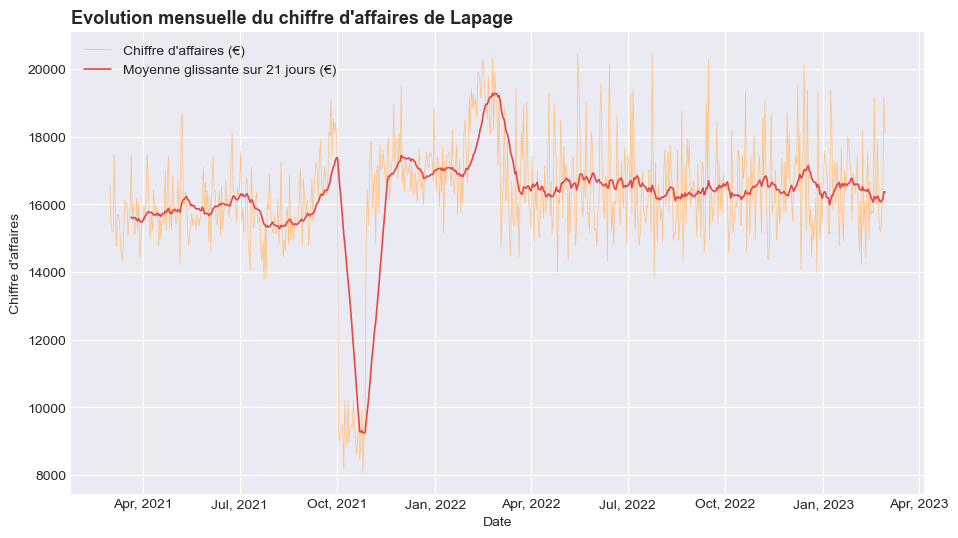

In [50]:
date = evol_ca["date"]
price = evol_ca["revenues"]
rolling = evol_ca["21day_rolling_avg"]

fig, ax = plt.subplots(figsize=(11, 6))

month_year_formatter = mdates.DateFormatter('%b, %Y')
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_formatter(month_year_formatter)

ax.plot(date, price, color="#FFC07D", linewidth=0.5)
ax.plot(date, rolling, color="#E74646", linewidth=1.2)

plt.title("Evolution mensuelle du chiffre d'affaires de Lapage", loc='left', fontsize=13, fontweight="bold")
plt.legend(["Chiffre d'affaires (€)", "Moyenne glissante sur 21 jours (€)"])
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")

plt.show()

Nous constatons un pic descendant en octobre 2021. 

### Coefficient saisonnier

In [51]:
ca_mensuelle = evol_ca.groupby(df_lapage["date"]).agg({"revenues": "sum"})

In [52]:
ca_moyenne_int = round(evol_ca["revenues"].sum() / 12, 2)
ca_moyenne = '{:,.2f}'.format(ca_moyenne_int)

print("La moyenne générale mensuelle est de", ca_moyenne, "€")

La moyenne générale mensuelle est de 987,810.72 €


Nous calculons le coefficient en divisant le chiffre d'affaires mensuelle par le chiffre d'affaires moyen mensuelle.

In [53]:
ca_mensuelle["coeff"] = (ca_mensuelle["revenues"] / ca_moyenne_int)
ca_mensuelle = ca_mensuelle.round(3).reset_index()
display(ca_mensuelle.head())

,date,revenues,coeff
0,2021-03-03,14235.62,0.014
1,2021-03-10,27403.76,0.028
2,2021-03-13,48047.73,0.049
3,2021-03-14,47053.08,0.048
4,2021-03-15,16919.19,0.017


Affichons les variations de ce coefficient sous forme de courbe.

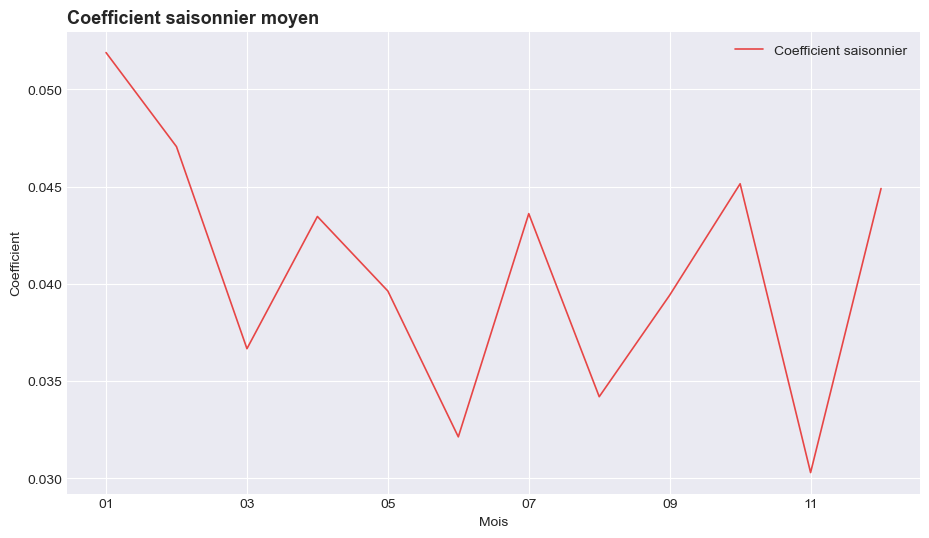

In [54]:
ca_mensuelle.groupby(ca_mensuelle["date"].dt.strftime('%m')).agg({"coeff": "mean"}).plot(legend=True, color="#E74646", linewidth=1.2, figsize=(11, 6))

plt.xlabel("Mois")
plt.ylabel("Coefficient")
plt.title("Coefficient saisonnier moyen", loc='left', fontsize=13, fontweight="bold")
plt.legend(["Coefficient saisonnier"])

plt.show()

Nous pouvons conclure que les mois de janvier, octobre et décembre sont les mois les plus saisonniers. 

Il serait justicieux de faire des promotions en mars, juin, août et novembre pour lisser cette courbe.

## 1.2 Croissance du chiffre d'affaires<a class="anchor" id="sous_partie4-1-2"></a>

In [55]:
changes = df_lapage_vente.groupby(df_lapage["date"].dt.to_period('Y')).agg({"price": "sum"})
changes.rename(columns={"id_prod": "nb_sales"}, inplace=True)
changes["evol"] = (changes["price"].pct_change()*100)
display(changes.round(2))

,price,evol
date,,
2021,4770826.56,NaN
2022,6108681.81,28.04
2023,974220.31,-84.05


## 1.3 Chiffre d'affaires total<a class="anchor" id="sous_partie4-1-1"></a>

In [56]:
ca_lapage_int = df_lapage_vente["price"].sum()
ca_lapage = '{:,.2f}'.format(ca_lapage_int)

print("Le total du chiffre d'affaires réalisé en ligne s'élève à", ca_lapage, "€")

Le total du chiffre d'affaires réalisé en ligne s'élève à 11,853,728.68 €


Avec l'estimation du produit vide :

In [57]:
ca_total_int = (ca_lapage_int + ca_produit_vide_int)
ca_total = '{:,.2f}'.format(ca_total_int)

print("Le total du chiffre d'affaires réalisé en ligne s'élève à", ca_total, "€")

Le total du chiffre d'affaires réalisé en ligne s'élève à 11,856,080.12 €


## 1.4 Octobre 2021 : pourquoi cette baisse ?<a class="anchor" id="sous_partie4-1-4"></a>

Isolons les données d'octobre 2021.

In [58]:
october = df_lapage_vente.loc[(df_lapage_vente["date"] >= "2021-10-01") & (df_lapage_vente["date"] <= "2021-10-31")]

In [59]:
evol_ca_october = october.groupby(october["date"]).agg({"price": "sum"})
evol_ca_october.rename(columns={"price": "revenues"}, inplace=True)
evol_ca_october = evol_ca_october.reset_index()
display(evol_ca_october.head().round(2))

,date,revenues
0,2021-10-01,17058.34
1,2021-10-02,9182.13
2,2021-10-03,8993.05
3,2021-10-04,9279.68
4,2021-10-05,9390.46


Affichons ces informations sous forme de graphique en courbe. Nous pouvons constater que la baisse du chiffre d'affaires est bien présente du 2 au 25 octobre.

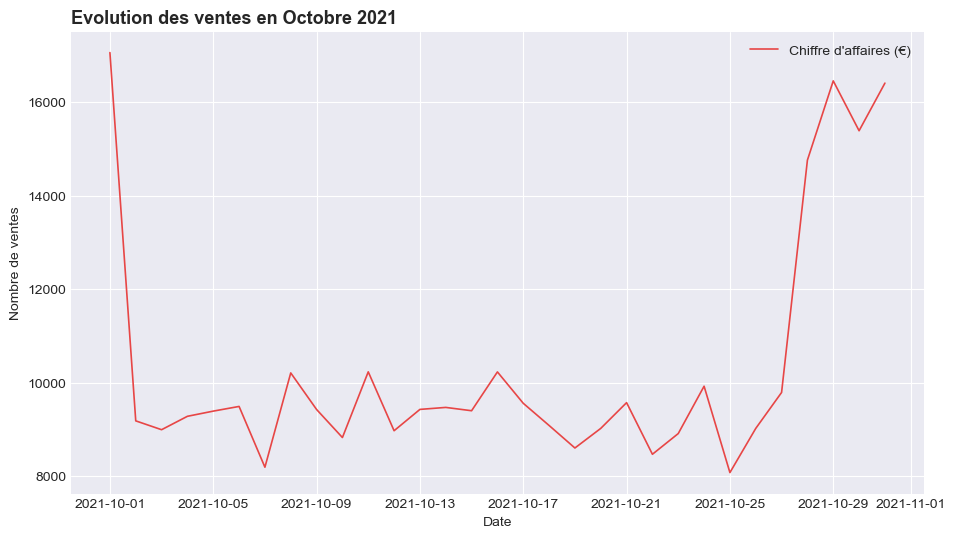

In [60]:
date = evol_ca_october["date"]
price = evol_ca_october["revenues"]

fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(date, price, linewidth=1.2, color="#E74646")

plt.title("Evolution des ventes en Octobre 2021", loc='left', fontsize=13, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nombre de ventes")
plt.legend(["Chiffre d'affaires (€)"])


plt.show()

Si nous regardons les ventes de chaque catégories :

In [61]:
categ_october = october.groupby(["categ"]).agg({"price": "sum", "id_prod": "count"})
categ_october.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)
display(categ_october)

,revenues,nb_sales
categ,,
0,199250.83,18762
1,33762.32,1666
2,87785.59,1171


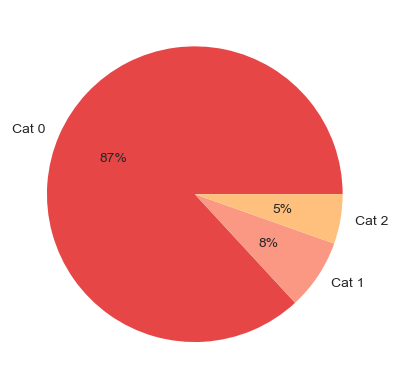

In [62]:
data = categ_october["nb_sales"]
labels = ["Cat 0", "Cat 1", "Cat 2"]
colors = ["#E74646", "#FA9884", "#FFC07D"]

plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

In [63]:
ca_categ_mois = df_lapage_vente.groupby([df_lapage["date"].dt.to_period('M'), "categ"]).agg({"price": "sum", "id_prod": "count"})
ca_categ_mois.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)

ca_categ0 = ca_categ_mois.query("categ == '0'").groupby(["date"])["revenues"].sum().reset_index()
ca_categ1 = ca_categ_mois.query("categ == '1'").groupby(["date"])["revenues"].sum().reset_index()
ca_categ2 = ca_categ_mois.query("categ == '2'").groupby(["date"])["revenues"].sum().reset_index()

Affichons ces informations sous forme de graphique en courbe.

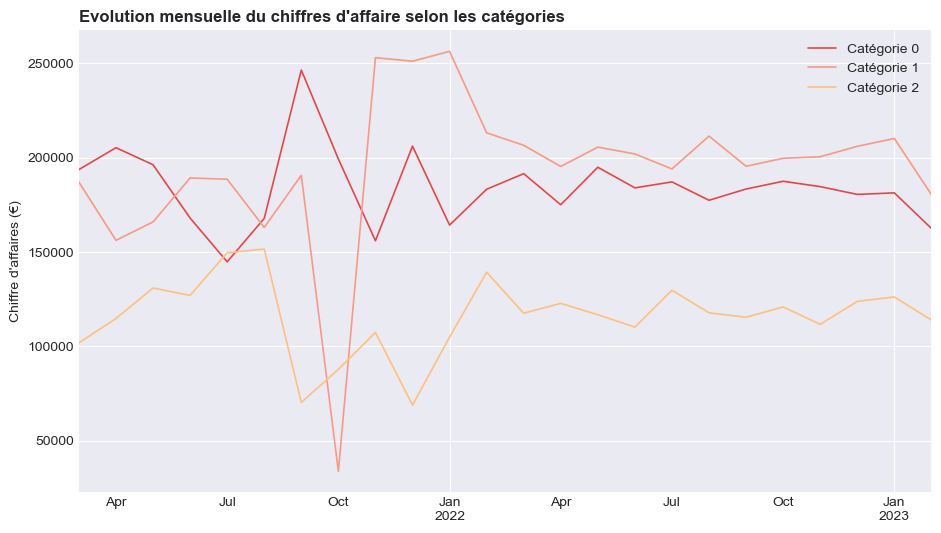

In [64]:
fig, ax = plt.subplots(figsize=(11, 6))

evol_categ = ca_categ0.groupby("date")["revenues"].sum().plot(linewidth=1.2, color="#E74646")
ca_categ1.groupby("date")["revenues"].sum().plot(linewidth=1.2, ylabel="Chiffre d'affaires (€)", color="#FA9884")
ax = ca_categ2.groupby("date")["revenues"].sum().plot(linewidth=1.2, xlabel="Mois", color="#FFC07D")

ax.set(xlabel=None)

plt.title("Evolution mensuelle du chiffres d'affaire selon les catégories", loc='left', fontsize=12, fontweight="bold")
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"])

plt.show()

Il semblerait que le chiffre d'affaires de la catégorie 1 a baissé en octobre 2021. Ce qui explique la baisse générale du chiffre d'affaires.

## 1.5 Prix moyen par catégorie<a class="anchor" id="sous_partie4-1-5"></a>

Les deux catégories en baisse sont celles avec des prix moyens supérieurs à 20 euros. 

In [65]:
prix_moyen_categ = df_lapage_vente.groupby(["categ"]).agg({"price": "mean"})
prix_moyen_categ.rename(columns={"price": "avg_price"}, inplace=True)
display(prix_moyen_categ.round(2))

,avg_price
categ,
0,10.64
1,20.49
2,76.21


## 1.6 Références : tops et flops<a class="anchor" id="sous_partie4-1-6"></a>

In [66]:
df_lapage_ref = df_lapage[["date", "id_prod", "price", "categ"]]

### Les 5 références les plus rentables

Les 5 références qui rapportent le plus de chiffre d'affaires sont principalement dans la catégorie 2. Rappelons que son prix moyen est de 76 euros.

In [67]:
ca_par_prod = df_lapage.groupby(["id_prod", "categ"]).agg({"price": "sum", "id_prod": "count"})
ca_par_prod.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)
ca_par_prod_top = ca_par_prod.sort_values("revenues", ascending=False)
display(ca_par_prod_top.head())

,,revenues,nb_sales
id_prod,categ,,
2_159,2,94893.50,650
2_135,2,69334.95,1005
2_112,2,65407.76,968
2_102,2,60736.78,1027
2_209,2,56971.86,814


### Les 5 références les moins rentables

Les références qui rapportent le moins de chiffre d'affaires sont la catégorie 0. Rappelons que son prix moyen est de 10 euros.

In [68]:
ca_par_prod_flop = ca_par_prod.sort_values("revenues", ascending=True)
display(ca_par_prod_flop.head())

,,revenues,nb_sales
id_prod,categ,,
0_1539,0,0.99,1
0_1284,0,1.38,1
0_1653,0,1.98,2
0_1601,0,1.99,1
0_807,0,1.99,1


Si nous trions par le nombre de ventes : la tendance change pour les tops, mais reste la même pour les flops.

### Les 5 références les plus vendus

Ici, les produits de la catégorie 1 sont les plus populaires.

In [69]:
vente_par_prod_top = ca_par_prod.sort_values("nb_sales", ascending=False)
display(vente_par_prod_top.head())

,,revenues,nb_sales
id_prod,categ,,
1_369,1,54025.48,2252
1_417,1,45947.11,2189
1_414,1,51949.40,2180
1_498,1,49731.36,2128
1_425,1,35611.04,2096


### Les 5 références les moins vendus

In [70]:
vente_par_prod_flop = ca_par_prod.sort_values("nb_sales", ascending=True)
display(vente_par_prod_flop.head())

,,revenues,nb_sales
id_prod,categ,,
0_2201,0,20.99,1
0_1601,0,1.99,1
0_549,0,2.99,1
2_81,2,86.99,1
0_807,0,1.99,1


En conclusion :
* La catégorie 2 rapporte le plus. 
* La catégorie 1 se vend le plus.
* La catégorie 0, qui est la plus accessible, n'est pas prisée.

## 1.7 Répartition des ventes par catégorie<a class="anchor" id="sous_partie4-1-8"></a>

In [71]:
ventes_cat = df_lapage.groupby(["categ"]).agg({"price": "sum", "id_prod": "count"})
ventes_cat.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
display(ventes_cat)

,revenues,nb_sales
categ,,
0,4419730.97,415459
1,4653722.69,227169
2,2780275.02,36483


La catégorie 0 représente plus de 60% des ventes de livre sur les trois dernières années.

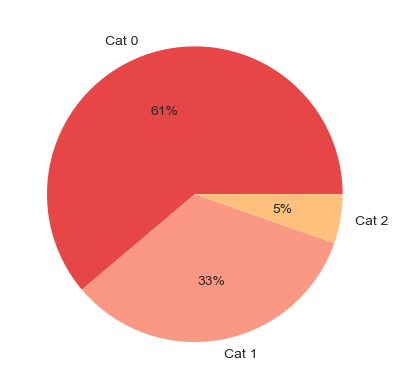

In [72]:
data = ventes_cat["nb_sales"]
labels = ["Cat 0", "Cat 1", "Cat 2"]
colors = ["#E74646", "#FA9884", "#FFC07D"]

plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

## 1.8 Répartition du chiffre d'affaires par catégorie<a class="anchor" id="sous_partie4-1-9"></a>

En effet, cette catégorie ne représente plus que 37% du chiffre d'affaires sur les trois dernières années.

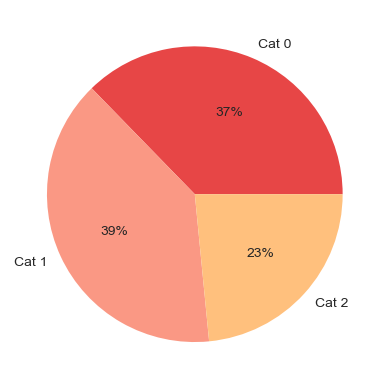

In [73]:
data = ventes_cat["revenues"]
labels = ["Cat 0", "Cat 1", "Cat 2"]
colors = ["#E74646", "#FA9884", "#FFC07D"]

plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

## 1.9 Chiffre d'affaires annuel par catégorie<a class="anchor" id="sous_partie4-1-7"></a>

In [74]:
cat_repart = df_lapage.pivot_table(values=["price"], index=[df_lapage["date"].dt.to_period('Y')], columns=['categ'], aggfunc=np.sum)
cat_repart.rename(columns={"0": "cat 1", "1": "cat 2", "2": "cat 3"}, inplace=True)
cat_repart.index.names = ["year"]
display(cat_repart)

price                        
categ       cat 1       cat 2       cat 3
year                                     
2021   1883020.45  1777995.85  1109810.26
2022   2192970.46  2485275.19  1430436.16
2023    343740.06   390451.65   240028.60

On observe que la catégorie 2 s'est mieux vendu en 2022 qu'en 2021. Elle prend également la tête début 2023.

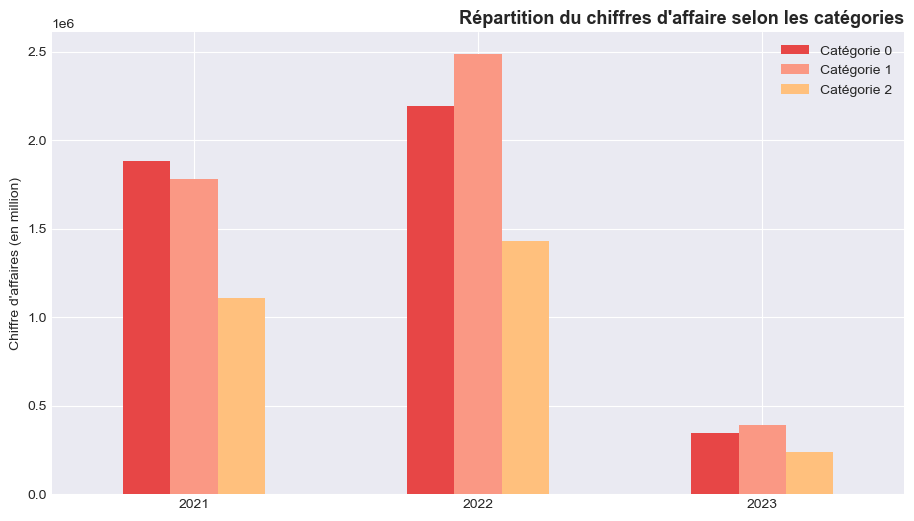

In [75]:
ax = cat_repart.plot(kind="bar", ylabel="Chiffre d'affaires (en million)", xlabel="Année", width=0.5, figsize=(11,6), color=["#E74646", "#FA9884", "#FFC07D"])

ax.set(xlabel=None)

plt.title("Répartition du chiffres d'affaire selon les catégories", loc="right", fontsize=13, fontweight="bold")
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"])

plt.xticks(rotation = 0)

plt.show()

Comme évoqué précédemment, cela peut s'expliquer par un prix moyen beaucoup moins élevés que les autres catégories.

In [76]:
prix_moyen_categ = df_lapage_vente.groupby(["categ"]).agg({"price": "mean"})
prix_moyen_categ.rename(columns={"price": "revenues"}, inplace=True)
display(prix_moyen_categ.round(2))

,revenues
categ,
0,10.64
1,20.49
2,76.21


Le prix moyen de la catégorie 2 semble d'ailleurs élevé, investiguons.

#### Prix moyen des meilleures ventes de la catégorie 2

In [77]:
prod_categ_2 = df_lapage_vente.loc[df_lapage_vente["categ"] == "2"]
prod_categ_2 = prod_categ_2.groupby(["id_prod", "price"]).agg({"id_prod": "count"})
prod_categ_2.rename(columns={"id_prod": "nb_sales"}, inplace=True)
top_10_cat_2 = prod_categ_2.sort_values("nb_sales", ascending=False).reset_index().head(10)
display(top_10_cat_2)

cat_2_avg = top_10_cat_2["price"].mean()
print("Le prix moyen des meilleures ventes de la catégorie 2 est de", round(cat_2_avg, 2), "€")

,id_prod,price,nb_sales
0,2_102,59.14,1027
1,2_135,68.99,1005
2,2_112,67.57,968
3,2_39,57.99,915
4,2_37,48.99,882
5,2_110,62.25,865
6,2_208,54.87,831
7,2_209,69.99,814
8,2_207,50.99,786
9,2_109,53.99,744


Le prix moyen des meilleures ventes de la catégorie 2 est de 59.48 €


#### Nombre de ventes moyen des meilleures ventes de la catégorie 2

In [78]:
top_10_prix_cat_2 = prod_categ_2.sort_values("price", ascending=False).reset_index().head(10)
display(top_10_prix_cat_2)

cat_2_prix_avg = top_10_prix_cat_2["nb_sales"].mean()
print("La moyenne des ventes des livres les plus chers de la catégorie 2 est de", round(cat_2_prix_avg), "exemplaires.")

,id_prod,price,nb_sales
0,2_2,300.00,15
1,2_76,254.44,9
2,2_158,247.22,142
3,2_167,236.99,189
4,2_30,233.54,7
5,2_125,231.99,7
6,2_166,230.04,228
7,2_40,228.11,26
8,2_228,225.17,75
9,2_4,222.97,6


La moyenne des ventes des livres les plus chers de la catégorie 2 est de 70 exemplaires.


# Profils client<a class="anchor" id="sous_partie4-2"></a>

Rappelons que seules les clients actives sont pris en compte dans ces profils clients.

In [79]:
df_client = df_lapage[["date", "client_id", "age", "sex", "id_prod", "price", "categ"]]

## 1.1 Chiffre d'affaires par client<a class="anchor" id="sous_partie4-1-10"></a>

Ici, l'id_prod équivaut à un produit acheté donc nous comptons également combien de fois un client a effectué un achat.

Au vu du nombre de ventes, nous pouvons faire l'hypothèse qu'il existe quatre clients B2B : c_1609, c_4958, c_6714 et c_3454.

In [80]:
ca_par_client = df_lapage.groupby(["client_id", "sex", "age"]).agg({"price": "sum", "id_prod": "count"})
ca_par_client.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
ca_par_client = ca_par_client.sort_values("revenues", ascending=False).reset_index()
display(ca_par_client)

,client_id,sex,age,revenues,nb_sales
0,c_1609,m,43,324033.35,25488
1,c_4958,m,24,289760.34,5195
2,c_6714,f,55,153598.92,9181
3,c_3454,m,54,113637.93,6770
4,c_3263,f,38,5276.87,403
...,...,...,...,...,...
8595,c_4648,m,19,11.20,1
8596,c_240,m,25,11.06,1
8597,c_8114,m,61,9.98,2
8598,c_8140,m,52,8.30,2


### Courbe de Lorenz

Il semblerait que 50 % du chiffre d’affaires est détenu par 80 % des clients. 

La courbe de Lorenz (en rouge) représente la part du chiffre d'affaires détenu par les clients lorsqu’on les classe par chiffre d'affaires générés croissant. Plus les courbes s’éloignent de la diagonale (en bleu), plus la distribution est inégalitaire

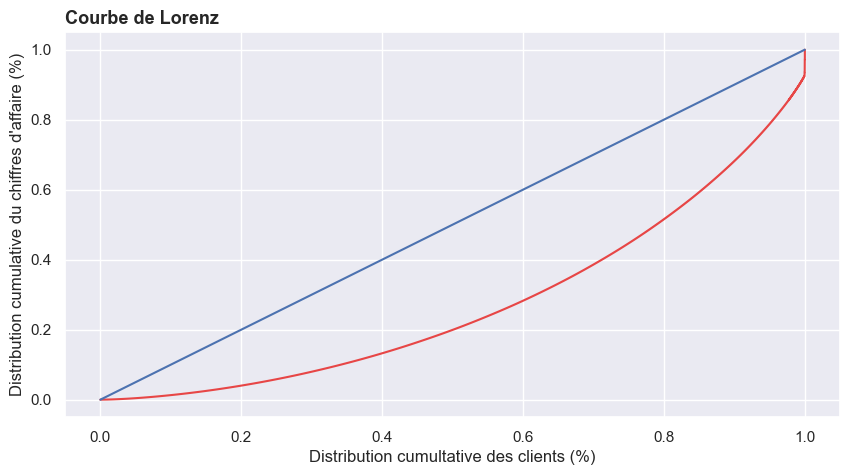

In [81]:
sb.set(rc={'figure.figsize':(10, 5)})

prix = ca_par_client["revenues"].values
n = len(prix)
lorenz = np.cumsum(np.sort(prix)) / prix.sum()
lorenz = np.append([0], lorenz) 

xaxis = np.linspace(0-1/n,1+1/n,len(lorenz))
plt.plot(xaxis, lorenz, drawstyle='steps-post', color='#E74646')
plt.plot([0,1], [0,1]) 

plt.xlabel("Distribution cumultative des clients (%)")
plt.ylabel("Distribution cumulative du chiffres d'affaire (%)")
plt.title("Courbe de Lorenz", loc="left", fontsize=13, fontweight="bold")

plt.show()

### Indice de GINI

Plus les inégalités sont importantes, plus la courbe de Lorenz s’éloigne de la diagonale, plus l’indice de Gini est élevé.

In [82]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC 
gini = 2*S

print("L'indice de GINI est de", round(gini, 2))

L'indice de GINI est de 0.45


## 1.2 Lien entre l’âge et le montant total des achats<a class="anchor" id="sous_partie4-2-2"></a>

### 1. Sur l'ensemble des âges

Nous agrégeons une table pour trouver le montant total des achats par âge.

Les clients ayant 43 ans sont ceux qui ont dépensé le plus. 

In [83]:
ca_client_age = df_client.groupby("age").agg({"price": "sum"})
ca_client_age = ca_client_age.sort_values("price", ascending=False)
ca_client_age = ca_client_age.reset_index()
display(ca_client_age.head())

,age,price
0,43,613614.58
1,19,609013.69
2,24,489497.54
3,44,334267.72
4,35,330760.73


Les clients entre 30 et 50 ans ont dépensé entre 200 000 et 300 000 euros.

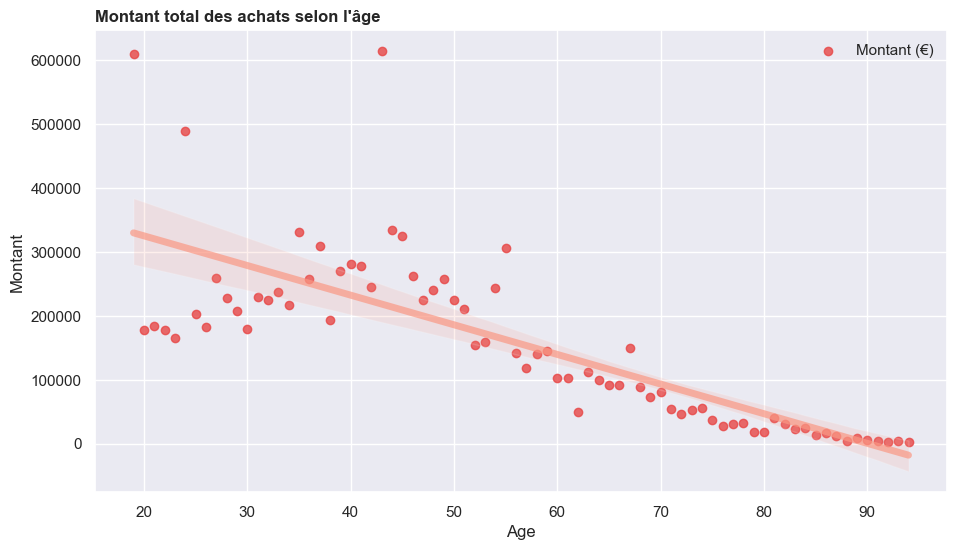

In [84]:
fig, ax = plt.subplots(figsize=(11, 6))

ax = sb.regplot(x=ca_client_age["age"], y=ca_client_age["price"], color="#E74646", line_kws={"color":"#FA9884","alpha":0.7,"lw":5})

plt.title("Montant total des achats selon l'âge", loc="left", fontsize=12, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Montant")
plt.legend(["Montant (€)"], loc="upper right")

plt.show()

Nous émettons l'hypothèse que les points les plus éloignés sont dû à nos clients B2B.

### Tests statistique

1. Pearson

In [85]:
list1 = ca_client_age["age"]
list2 = ca_client_age["price"]

resultats_test = pearsonr(list1, list2)

print("coefficient de pearson :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

coefficient de pearson : -0.779
p_valeur : 0.0


Ces deux variables ont une forte corrélation négative (inverse).

Plus les clients sont âgés, moins ils dépensent.

2. Shapiro

H0 : L'échantillon provient d'une distribution normale (Po > 0.05).

In [86]:
resultats_test = shapiro(ca_client_age)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.696
p_valeur : 0.0


La p-value est de 0.696. Ce qui est supérieur au seuil 0.05.

Nous ne rejetons pas l'hypothèse nulle. 

Les données semblent normalement distribués.

### 2. Par groupe d'âge

Nous assignons des groupes d'âge aux clients.

In [87]:
df_age = df_client.assign(agegroup=pd.cut(df_client["age"], bins=[18, 25, 35, 45, 55, 65, 75, 85, 95], right=False, labels=["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"]))

Nous calculons combien de clients nous avons dans chacune de ses tranches d'âge.

In [88]:
repartition_age = df_age.groupby(["agegroup"])["age"].count()
repartition_age = repartition_age.reset_index()
repartition_age.rename(columns={"age": "nb of people"}, inplace=True)
repartition_age["percent"] = round((repartition_age["nb of people"] / repartition_age["nb of people"].sum()) * 100, 2)
display(repartition_age)

,agegroup,nb of people,percent
0,18-24,43010,6.33
1,25-34,87893,12.94
2,35-44,235773,34.72
3,45-54,165458,24.36
4,55-64,78445,11.55
5,65-74,47048,6.93
6,75-84,16891,2.49
7,+85,4593,0.68


Environ 35% de nos clients ont entre 35 et 44 ans.

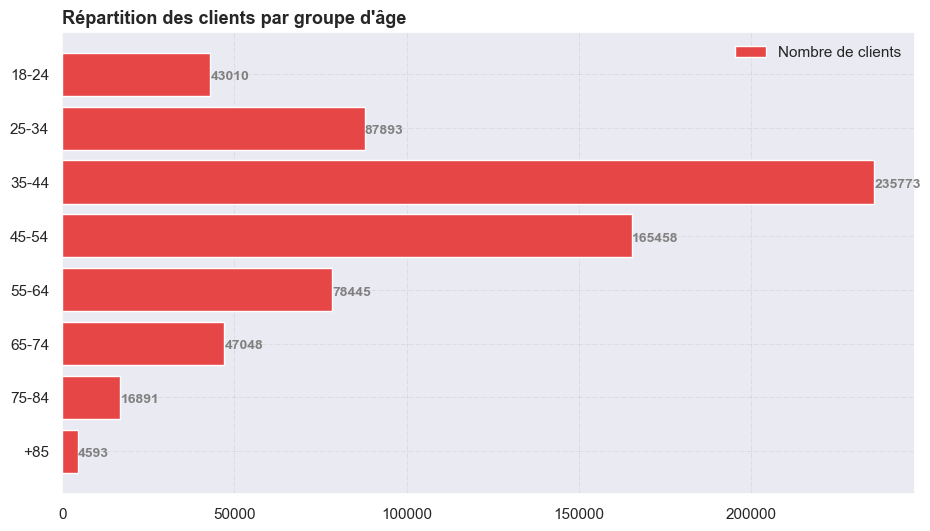

In [89]:
agegroup = repartition_age["agegroup"]
age = repartition_age["nb of people"]

fig, ax = plt.subplots(figsize=(11, 6))

ax.barh(agegroup, age, color="#E74646")

ax.grid(True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Répartition des clients par groupe d'âge", loc="left", fontsize=13, fontweight="bold")
plt.legend(["Nombre de clients"], loc="upper right")

plt.show()

Un tableau de croisement entre les modalités des deux variables.

In [90]:
repart_age = df_age.pivot_table(index="client_id", columns="agegroup", values="price", aggfunc=sum)
display(repart_age.head())

agegroup,18-24,25-34,35-44,45-54,55-64,65-74,75-84,+85
client_id,,,,,,,,
c_1,0.0,0.00,0.00,0.0,0.00,558.18,0.0,0.0
c_10,0.0,0.00,0.00,0.0,0.00,1353.60,0.0,0.0
c_100,0.0,254.85,0.00,0.0,0.00,0.00,0.0,0.0
c_1000,0.0,0.00,0.00,0.0,2261.89,0.00,0.0,0.0
c_1001,0.0,0.00,1812.86,0.0,0.00,0.00,0.0,0.0


Nous agrégeons les montants et le nombre de ventes total par groupe d'âge.

In [91]:
ca_cat_age = df_age.groupby("agegroup").agg({"price": "sum", "id_prod": "count"})
ca_cat_age.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
display(ca_cat_age)

,revenues,nb_sales
agegroup,,
18-24,1804390.04,43010
25-34,2169074.75,87893
35-44,3113186.74,235773
45-54,2301978.61,165458
55-64,1318421.01,78445
65-74,786360.72,47048
75-84,283137.49,16891
+85,77179.32,4593


Nous gardons la colonne revenues pour générer le graphique.

In [92]:
total_ca_age = ca_cat_age[["revenues"]]

Nous observons que les 35-44 génèrent le plus de chiffre d'affaires. Ils ont dépensé plus de 3 millions d'euros sur les trois dernières années.

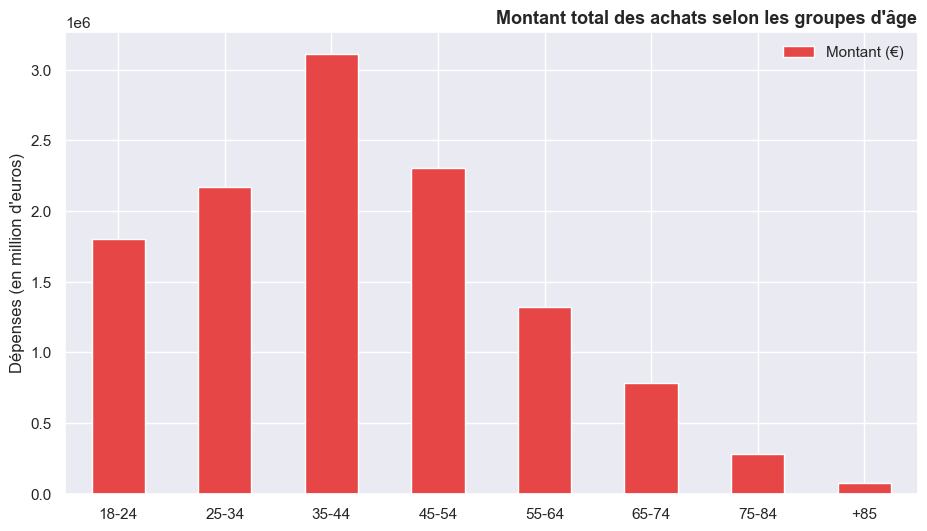

In [93]:
ax = total_ca_age.plot(kind="bar", ylabel="Dépenses (en million d'euros)", width = 0.5, figsize=(11,6), color="#E74646")

ax.set(xlabel=None)

plt.title("Montant total des achats selon les groupes d'âge", loc="right", fontsize=13, fontweight="bold")
plt.legend(["Montant (€)"], loc="upper right");

plt.xticks(rotation = 0)

plt.show()

### Tests statistique

1. ANOVA

H0 : Les moyennes de toute la population sont égales.

In [94]:
fvalue, pvalue = stats.f_oneway(repart_age["18-24"], repart_age["25-34"], repart_age["35-44"], repart_age["45-54"], repart_age["55-64"], repart_age["65-74"], repart_age["75-84"], repart_age["+85"])

print("statistique de test :", round(fvalue, 3))
print("p_valeur :", round(pvalue, 3))

statistique de test : 36.621
p_valeur : 0.0


La p-value est inférieur à 0.05. 

Nous rejetons l'hypothèse nulle.

Cela signifie que nous disposons de preuves suffisantes pour affirmer qu'il existe une différence de montant dépensé entre les 8 groupes d'âge.

2. Shapiro

H0 : L'échantillon provient d'une distribution normale (Po > 0.05).

In [95]:
resultats_test = shapiro(total_ca_age)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.962
p_valeur : 0.832


La p-value est de 0.832. Ce qui est supérieur au seuil 0.05. 

Nous ne rejetons pas l'hypothèse nulle. 

Les données semblent normalement distribués.

## 1.3 Lien entre l’âge et la taille du panier moyen<a class="anchor" id="sous_partie4-2-4"></a>

### 1. Sur l'ensemble des âges

Nous agrégons une table pour trouver la taille moyen du panier par âge.

In [96]:
df_panier = df_age.groupby(["client_id", "age"]).agg({"price": "sum", "id_prod": "count"})
df_panier.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
df_panier = df_panier.sort_values("revenues", ascending=False).reset_index()

#### Panier moyen par client

In [97]:
df_panier["basket_size"] = df_panier["revenues"] / df_panier["nb_sales"]
df_panier = df_panier.sort_values("basket_size", ascending=False)
df_panier = df_panier.reset_index().round(2)
display(df_panier.head())

,index,client_id,age,revenues,nb_sales,basket_size
0,7357,c_4391,22,363.98,2,181.99
1,7356,c_4540,20,363.98,2,181.99
2,4264,c_2369,24,1037.69,7,148.24
3,4796,c_1868,28,907.87,7,129.70
4,6692,c_755,27,498.45,4,124.61


#### Panier moyen global

In [98]:
panier_moyen = df_panier["basket_size"].mean()

print("Le panier moyen de l'ensemble des clients est de", round(panier_moyen, 2), "€")

Le panier moyen de l'ensemble des clients est de 22.02 €


Nous pouvons voir que les clients ayant la vingtaine sont ceux qui ont les paniers moyens les plus elevés. 

In [99]:
panier_moyen_age = df_panier.groupby("age").agg({"basket_size": "mean"})
panier_moyen_age = panier_moyen_age.round(2)
panier_moyen_age = panier_moyen_age.sort_values("basket_size", ascending=False).reset_index()
display(panier_moyen_age.head())

,age,basket_size
0,22,44.88
1,20,44.40
2,25,43.69
3,27,43.52
4,31,42.09


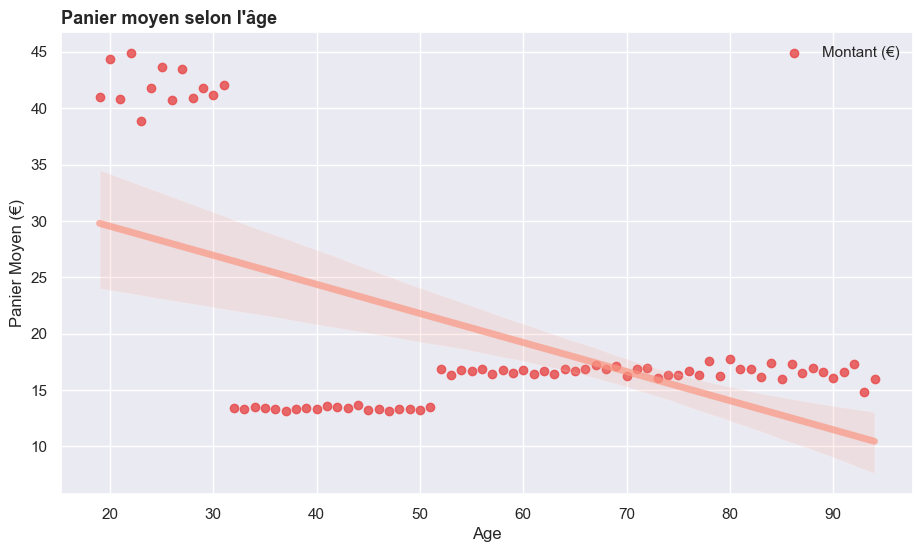

In [100]:
fig, ax = plt.subplots(figsize=(11, 6))

ax = sb.regplot(x=panier_moyen_age["age"], y=panier_moyen_age["basket_size"], color="#E74646", line_kws={"color":"#FA9884","alpha":0.7,"lw":5})

plt.title("Panier moyen selon l'âge", loc="left", fontsize=13, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Panier Moyen (€)")

plt.legend(["Montant (€)"], loc="upper right")

plt.show()

### Tests statistique

1. Pearson

In [101]:
list1 = panier_moyen_age["age"]
list2 = panier_moyen_age["basket_size"]

resultats_test = pearsonr(list1, list2)

print("coefficient de pearson :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

coefficient de pearson : -0.563
p_valeur : 0.0


Ces deux variables ont une corrélation négative (inverse).

Plus les clients sont âgés, moins le panier moyen est élevé.

2. Shapiro

In [102]:
resultats_test = shapiro(panier_moyen_age)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.856
p_valeur : 0.0


La p-value est de 0.0. Ce qui est inférieur au seuil 0.05.

Nous rejetons l'hypothèse nulle. 

Les données ne proviennent pas d'une distribution normale.

In [103]:
gfg_data = poisson(panier_moyen_age)
resultats_test = shapiro(gfg_data)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.89
p_valeur : 0.0


La p-value est de 0.0. Ce qui est inférieur à l'alpha (0.05).

Nous rejetons l'hypothèse nulle, c'est-à-dire que nous disposons de suffisamment d'éléments pour affirmer que l'échantillon ne provient pas d'une distribution normale.

Il faudrait investiguer pour en savoir plus :
* Il y a-t-il des valeurs aberrantes ?
* Les données sont asymétriques ?
* La taille de l'échantillon est trop grande ?

### 2. Par groupe d'âge

Nous réassignons les groupes d'âge à chaque client.

In [104]:
df_panier_moyen = df_panier.assign(agegroup=pd.cut(df_panier["age"], bins=[18, 25, 35, 45, 55, 65, 75, 85, 95], right=False, labels=["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"]))

Un tableau de croisement entre les modalités des deux variables.

In [105]:
panier_age = df_panier_moyen.pivot_table(index="client_id", columns="agegroup", values="basket_size", aggfunc=np.average)
display(panier_age.head())

agegroup,18-24,25-34,35-44,45-54,55-64,65-74,75-84,+85
client_id,,,,,,,,
c_1,NaN,NaN,NaN,NaN,NaN,14.31,NaN,NaN
c_10,NaN,NaN,NaN,NaN,NaN,23.34,NaN,NaN
c_100,NaN,31.86,NaN,NaN,NaN,NaN,NaN,NaN
c_1000,NaN,NaN,NaN,NaN,18.1,NaN,NaN,NaN
c_1001,NaN,NaN,17.77,NaN,NaN,NaN,NaN,NaN


Nous agrégons les paniers moyens par tranche d'âge.

In [106]:
age_panier_moyen = df_panier_moyen.groupby(["agegroup"])["basket_size"].mean()
display(age_panier_moyen.reset_index().round(2))

,agegroup,basket_size
0,18-24,41.67
1,25-34,33.92
2,35-44,13.41
3,45-54,14.27
4,55-64,16.65
5,65-74,16.79
6,75-84,16.80
7,+85,16.53


Il semblerait que les 18-24 ans ont des paniers plus élevés que le reste des groupes d'âge.

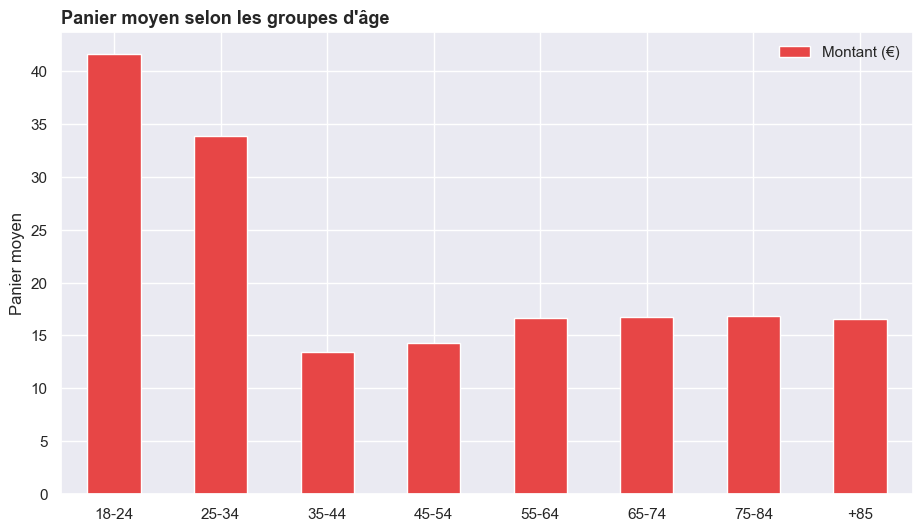

In [107]:
ax = age_panier_moyen.plot(kind="bar", ylabel="Panier moyen", width = 0.5, figsize=(11,6), color="#E74646")

ax.set(xlabel=None)

plt.title("Panier moyen selon les groupes d'âge", loc="left", fontsize=13, fontweight="bold")
plt.legend(["Montant (€)"], loc="upper right");

plt.xticks(rotation = 0)

plt.show()

### Tests statistique

1. ANOVA

H0 : Les moyennes de toute la population sont égales.

In [108]:
fvalue, pvalue = stats.f_oneway(panier_age["18-24"].dropna(), panier_age["25-34"].dropna(), panier_age["35-44"].dropna(), panier_age["45-54"].dropna(), panier_age["55-64"].dropna(), panier_age["65-74"].dropna(), panier_age["75-84"].dropna(), panier_age["+85"].dropna())

print("statistique de test :", round(fvalue, 3))
print("p_valeur :", round(pvalue, 3))

statistique de test : 1214.714
p_valeur : 0.0


La p-value est inférieur à 0.05. 

Nous rejetons l'hypothèse nulle.

Cela signifie que nous disposons de preuves suffisantes pour affirmer qu'il existe une différence de panier moyen entre les 8 groupes d'âge.

2. Shapiro

H0 : L'échantillon provient d'une distribution normale (Po > 0.05).

In [109]:
resultats_test = shapiro(age_panier_moyen)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.708
p_valeur : 0.003


La p-value est de 0.003. Ce qui est inférieur à l'alpha (0.05).

Les données ne proviennent pas d'une distribution normale.

In [110]:
gfg_data = poisson(age_panier_moyen)
resultats_test = shapiro(gfg_data)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

statistique de test : 0.94
p_valeur : 0.611


La p-value est de 0.0943. Ce qui est supérieur à l'alpha (0.05).

Nous ne pouvons pas rejeter l'hypothèse nulle. 

Autrement dit, nous ne disposons pas de suffisamment d'éléments pour affirmer que l'échantillon provient d'une distribution normale.

## 1.4 Lien entre l’âge et la fréquence d'achat<a class="anchor" id="sous_partie4-2-3"></a>

Segmentons les clients en leur attribuant un score RFM.

In [111]:
df_age["date"].max()

Timestamp('2023-02-28 00:00:00')

Nous constatons que la date du dernier achat est le 2023-02-28. Nous pouvons déterminer notre date d'analyse comme étant le 2023-03-01.

In [112]:
now = dt.datetime(2023,3,1)

Créons une dataset pour le RFM.

In [113]:
rfm = df_age.groupby(["client_id", "age"]).agg({"date": lambda day: (now - day.max()).days, "id_prod": lambda num: len(num),"price": "sum"})
col_list = ["récence","fréquence","monétaire"]
rfm.columns = col_list
display(rfm.head())

,,récence,fréquence,monétaire
client_id,age,,,
c_1,68,45,39,558.18
c_10,67,33,58,1353.60
c_100,31,162,8,254.85
c_1000,57,36,125,2261.89
c_1001,41,6,102,1812.86


Assignons des scores à chacune des catégories et un score global à chaque client.

In [114]:
rfm["r"] = pd.qcut(rfm["récence"], 5, labels=[5,4,3,2,1])
rfm["f"] = pd.qcut(rfm["fréquence"], 5, labels=[1,2,3,4,5])
rfm["m"] = pd.qcut(rfm["monétaire"], 5, labels=[1,2,3,4,5])
rfm["rfm_score"] = rfm["r"].astype(str) + rfm["f"].astype(str) + rfm["m"].astype(str)

Nous attribuons des noms de segment à chacun de nos clients en fonction de leur score global.

In [115]:
seg_map = {
    r"[1-2][1-2]": "Faible",
    r"[1-2][3-4]": "Faible",
    r"[1-2]5": "Faible",
    
    r"3[1-2]": "Moyen",
    r"33": "Moyen",
    r"[3-4][4-5]": "Moyen",    
    r"41": "Moyen",
    
    r"51": "Fort",
    r"[4-5][2-3]": "Fort",
    r"5[4-5]": "Fort"
}

In [116]:
rfm["segment"] = rfm["r"].astype(str) + rfm["f"].astype(str)
rfm["segment"] = rfm["segment"].replace(seg_map, regex=True)
display(rfm.head())

,,récence,fréquence,monétaire,r,f,m,rfm_score,segment
client_id,age,,,,,,,,
c_1,68,45,39,558.18,2,2,2,222,Faible
c_10,67,33,58,1353.60,2,3,4,234,Faible
c_100,31,162,8,254.85,1,1,1,111,Faible
c_1000,57,36,125,2261.89,2,5,5,255,Faible
c_1001,41,6,102,1812.86,4,4,4,444,Moyen


Nous pouvons drop les colonnes sauf le rfm_score et le segment.

In [117]:
rfm = rfm.drop(columns=["récence","fréquence", "monétaire", "r", "f", "m"]).reset_index()

Nous réassignons les tranches d'âge à chaque client.

In [118]:
df_age_fréquence = rfm.assign(agegroup=pd.cut(rfm["age"], bins=[18, 25, 35, 45, 55, 65, 75, 85, 95], right=False, labels=["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"]))

Presque 40 % de nos clients sont dans le segment Faible.

In [119]:
df_rfm = df_age_fréquence.groupby(["segment"])["client_id"].count().reset_index()
df_rfm.rename(columns={"client_id": "nb of people"}, inplace=True)
df_rfm["percent"] = round((df_rfm["nb of people"] / df_rfm["nb of people"].sum()) * 100, 2)
display(df_rfm)

,segment,nb of people,percent
0,Faible,3396,39.49
1,Fort,2435,28.31
2,Moyen,2769,32.20


Nous organisons les catégories pour afficher le graphique.

In [120]:
segment = ["Faible", "Moyen", "Fort"]
mapping = {segment: i for i, segment in enumerate(segment)}
key = df_rfm["segment"].map(mapping)
df_rfm = df_rfm.iloc[key.argsort()]

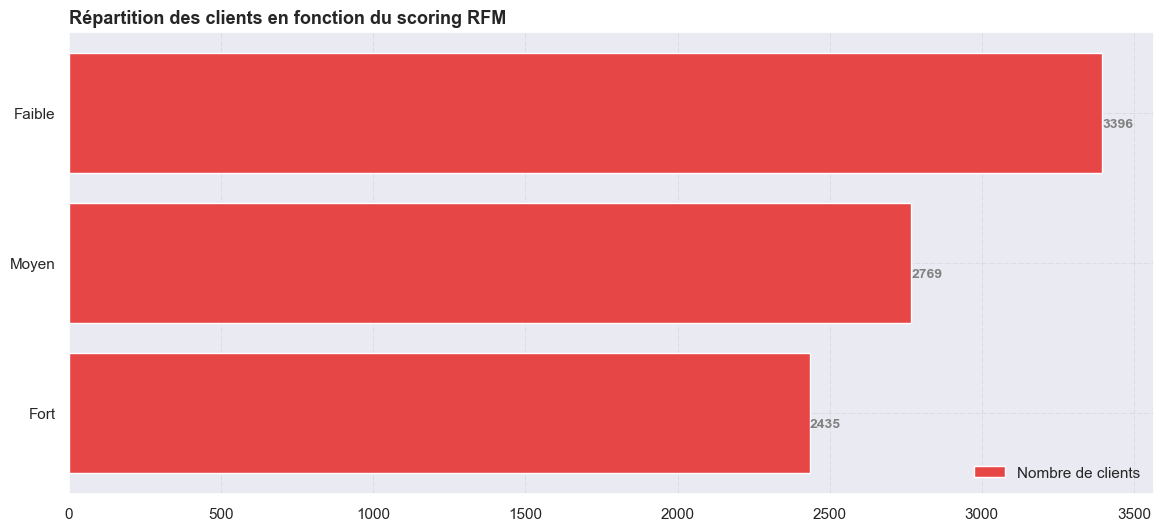

In [121]:
segment = df_rfm["segment"]
number = df_rfm["nb of people"]

fig, ax = plt.subplots(figsize=(14, 6))

ax.barh(segment, number, color="#E74646")

ax.grid(True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Répartition des clients en fonction du scoring RFM",loc="left", fontsize=13, fontweight="bold")
plt.legend(["Nombre de clients"], loc="lower right")

plt.show()

Un tableau de croisement entre les modalités des deux variables.

In [122]:
frequence_client_age = df_age_fréquence.pivot_table(index="segment", columns="agegroup", values="rfm_score", aggfunc=len, margins=True, margins_name="total")
display(frequence_client_age)

agegroup,18-24,25-34,35-44,45-54,55-64,65-74,75-84,+85,total
segment,,,,,,,,,
Faible,629,781,520,522,471,322,116,35,3396
Fort,260,382,541,503,365,257,100,27,2435
Moyen,258,398,719,585,393,286,99,31,2769
total,1147,1561,1780,1610,1229,865,315,93,8600


On enlève la ligne et la colonne "total" du dataset pour créer le graphique.

In [123]:
df_frequence = frequence_client_age.drop(["total"], axis=1)
df_frequence = df_frequence.drop(["total"], axis=0)

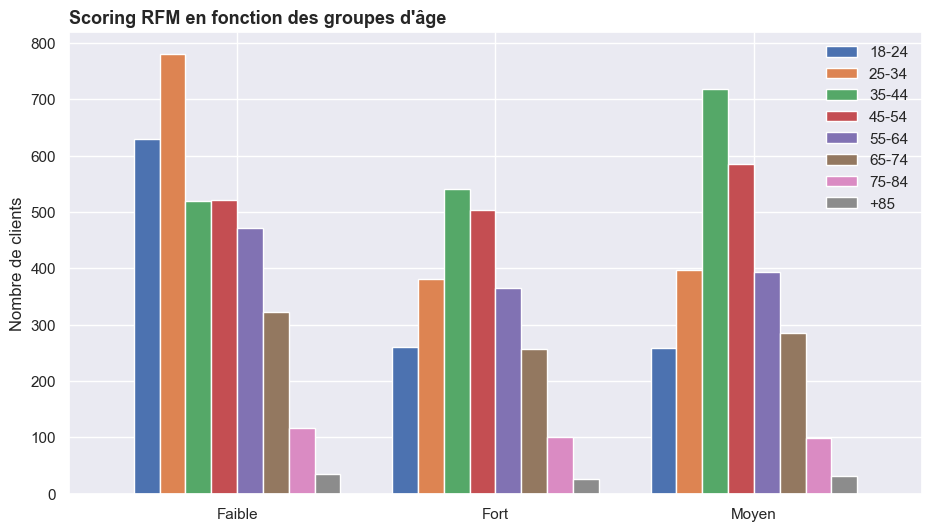

In [124]:
ax = df_frequence.plot(kind="bar", ylabel="Nombre de clients", width = 0.8, figsize=(11,6))

ax.set(xlabel=None)

plt.title("Scoring RFM en fonction des groupes d'âge", loc="left", fontsize=13, fontweight="bold")
plt.legend(["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"], loc="upper right")

plt.xticks(rotation = 0)

plt.show()

Nous créons également une heatmap.

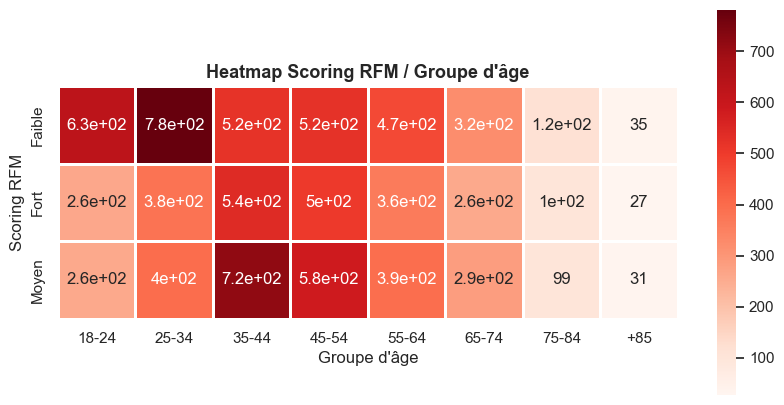

In [125]:
sb.heatmap(df_frequence, linewidths=2, square=True, cmap='Reds', annot=True)

plt.title("Heatmap Scoring RFM / Groupe d'âge", fontweight="bold", fontsize=13)
plt.xlabel("Groupe d'âge")
plt.ylabel("Scoring RFM")

plt.show()

### Tests statistique

1. Chi2

H0 : Les deux variables testées sont indépendantes.

In [126]:
resultats_test = stats.chi2_contingency(df_frequence)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))
print("degré de liberté :", resultats_test[2])

statistique de test : 315.256
p_valeur : 0.0
degré de liberté : 14


La p-value est inférieur à 0.05. 

On peut donc rejeter l’hypothèse selon laquelle les deux variables testées sont indépendantes.

Au vu du degré de liberté, notre Chi2 se situe à gauche de la colonne 0,05. Nous ne pouvons donc pas interpréter notre tableau sans prendre de risques.

En réduisant le nombre de lignes et/ou de cellules de ce tableau, il serait possible de valider le test du Chi2.

2. V de Cramer

In [127]:
X2 = resultats_test[0]
N = np.sum(df_frequence)
minimum_dimension = min(df_frequence.shape)-1

result = np.sqrt((X2/N) / minimum_dimension)
print(result)

agegroup
18-24    0.370711
25-34    0.317772
35-44    0.297582
45-54    0.312899
55-64    0.358130
65-74    0.426883
75-84    0.707394
+85      1.301894
dtype: float64


Si la valeur est renvoyée est supérieure à 0.9 on peut qualifier la relation de très forte. Si la valeur est inférieure à 0.10 on peut qualifier la relation de faible.

Il semblerait que ce soit les seniors qui sont le plus corrélé et les trentenaires qui sont le moins corrélé.

## 1.5 Lien entre l’âge et les catégories des livres achetés<a class="anchor" id="sous_partie4-2-5"></a>

### 1. Sur l'ensemble des âges

In [128]:
df_cat_age = df_client.groupby(["categ", "age"]).agg({"id_prod": "count"})
df_cat_age.rename(columns={"id_prod": "nb_sales"}, inplace=True)
df_cat_age = df_cat_age.sort_values("age", ascending=True).reset_index()

In [129]:
age_categ0 = df_cat_age.query("categ == '0'").groupby(["age"])["nb_sales"].sum().reset_index()
age_categ1 = df_cat_age.query("categ == '1'").groupby(["age"])["nb_sales"].sum().reset_index()
age_categ2 = df_cat_age.query("categ == '2'").groupby(["age"])["nb_sales"].sum().reset_index()

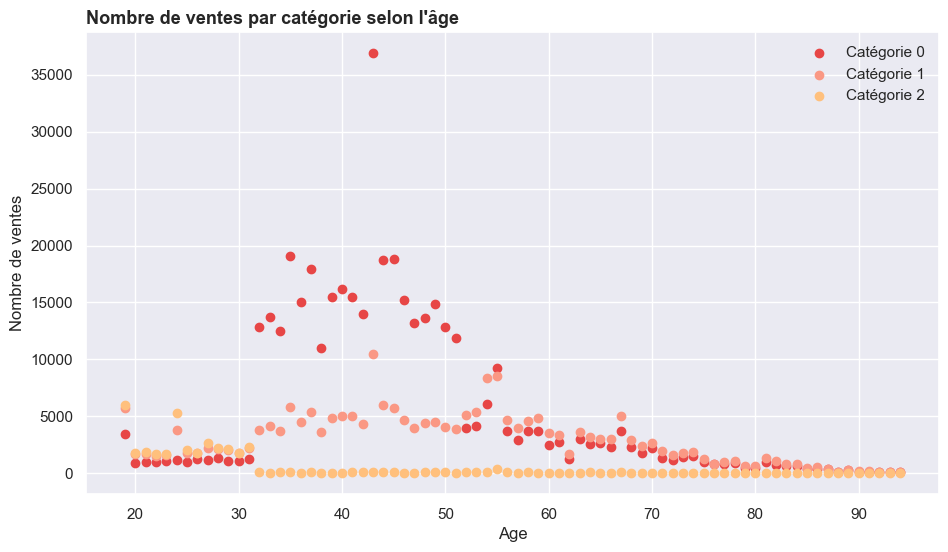

In [130]:
fig, ax = plt.subplots(figsize=(11, 6))

ax = plt.gca()

ax.scatter(age_categ0["age"], age_categ0["nb_sales"], color="#E74646")
ax.scatter(age_categ1["age"], age_categ1["nb_sales"], color="#FA9884")
ax.scatter(age_categ2["age"], age_categ2["nb_sales"], color="#FFC07D")

plt.title("Nombre de ventes par catégorie selon l'âge", loc="left", fontsize=13, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Nombre de ventes")

plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"], loc="upper right");

plt.show()

### Tests statistique

Pearson

In [131]:
list1 = df_cat_age["age"]
list2 = df_cat_age["nb_sales"]

resultats_test = pearsonr(list1, list2)

print("coefficient de pearson :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))

coefficient de pearson : -0.325
p_valeur : 0.0


Ces deux variables ont une corrélation moyenne négative.

L'âge des clients n'est pas vraiment corrélé avec les catégories de livre achetés.

### 2. Par groupe d'âge

Nous réassignons les groupes d'âge à chaque client.

In [132]:
df_categ = df_client.assign(agegroup=pd.cut(df_panier["age"], bins=[18, 25, 35, 45, 55, 65, 75, 85, 95], right=False, labels=["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"]))

Un tableau de croisement entre les modalités des deux variables, soit âge et catégorie.

In [133]:
df_categ_age = df_categ.pivot_table(index="agegroup", columns="categ", values="id_prod", aggfunc=len, margins=True, margins_name="total")
df_categ_age = df_categ_age.rename(columns={"0": "cat 0", "1": "cat 1", "2": "cat 2"})
display(df_categ_age)

categ,cat 0,cat 1,cat 2,total
agegroup,,,,
18-24,700,405,42,1147
25-34,942,571,48,1561
35-44,993,689,98,1780
45-54,926,613,69,1608
55-64,724,463,41,1228
65-74,514,324,27,865
75-84,190,110,14,314
+85,57,34,2,93
total,5046,3209,341,8596


On enlève la ligne et la colonne total du dataframe pour créer le graphique.

In [134]:
categ_age = df_categ_age.drop(["total"], axis=1)
categ_age = categ_age.drop(labels="total", axis=0)

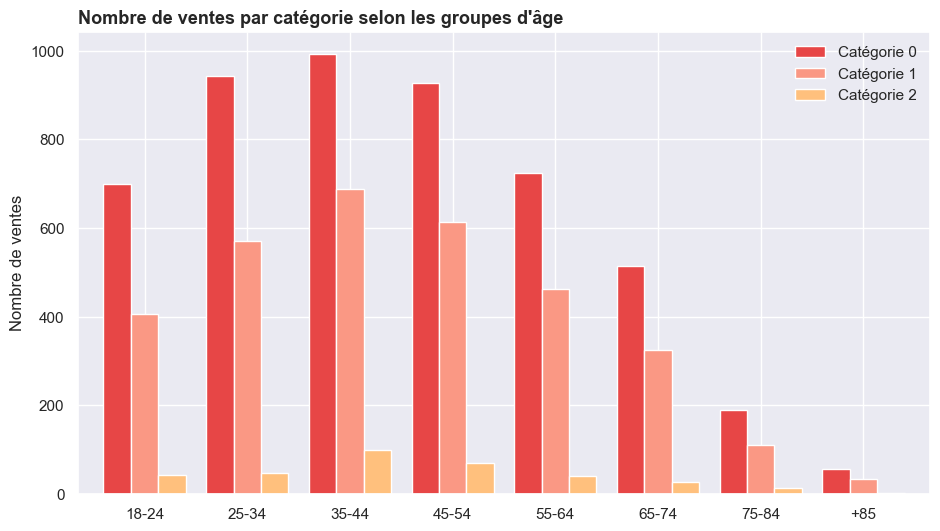

In [135]:
ax = categ_age.plot(kind="bar", ylabel="Nombre de ventes", width=0.8, figsize=(11,6), color=["#E74646", "#FA9884", "#FFC07D"])

ax.set(xlabel=None)

plt.title("Nombre de ventes par catégorie selon les groupes d'âge", loc="left", fontsize=13, fontweight="bold")
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"], loc="upper right")

plt.xticks(rotation = 0)

plt.show()

Nous créons également une heatmap.

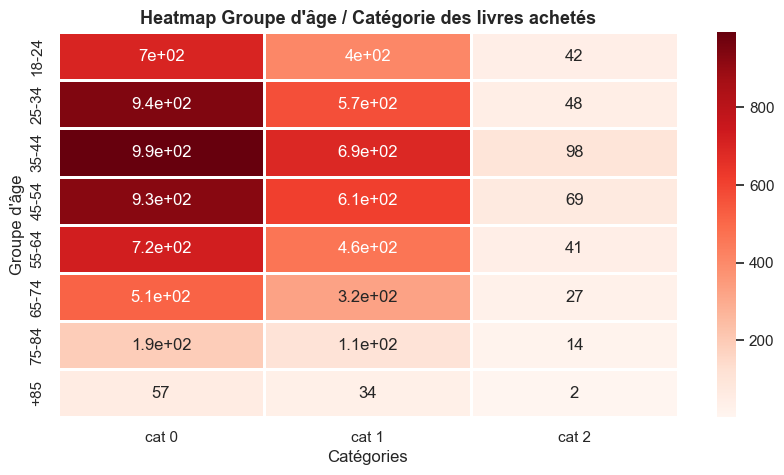

In [136]:
sb.heatmap(categ_age, linewidths=2, cmap='Reds', annot=True)

plt.title("Heatmap Groupe d'âge / Catégorie des livres achetés", fontweight="bold", fontsize=13)
plt.ylabel("Groupe d'âge")
plt.xlabel("Catégories")

plt.show()

### Tests statistique

1. Chi2

H0 : Les deux variables testées sont indépendantes.

In [137]:
resultats_test = stats.chi2_contingency(categ_age)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))
print("degré de liberté :", resultats_test[2])

statistique de test : 26.434
p_valeur : 0.023
degré de liberté : 14


La p-value est inférieur à 0.05. 

On peut donc rejeter l’hypothèse selon laquelle les deux variables testées sont indépendantes.

Au vu du degré de liberté, notre Chi2 se situe à gauche de la colonne 0,05. Nous ne pouvons donc pas interpréter notre tableau sans prendre de risques.

En réduisant le nombre de lignes et/ou de cellules de ce tableau, il serait possible de valider le test du Chi2.

2. V de Cramer

In [138]:
X2 = resultats_test[0]
N = np.sum(categ_age)
minimum_dimension = min(categ_age.shape)-1

result = np.sqrt((X2/N) / minimum_dimension)
print(result)

categ
cat 0    0.051179
cat 1    0.064177
cat 2    0.196875
dtype: float64


Si la valeur est renvoyée est supérieure à 0.9 on peut qualifier la relation de très forte. Si la valeur est inférieure à 0.10 on peut qualifier la relation de faible.

Il semblerait que ce soit la catégorie 2 qui soit le plus corrélé et la catégorie 0 qui soit le moins corrélé.

## 1.6 Lien entre le genre et les catégories des livres achetés<a class="anchor" id="sous_partie4-2-1"></a>

Un tableau de croisement entre les modalités des deux variables, soit genre et catégorie.

In [139]:
df_genre = df_client.pivot_table(index="sex", columns="categ", values="id_prod", aggfunc=len, margins=True, margins_name="total")
df_genre.rename(index={"f": "femmes", "m": "hommes"}, inplace=True)
df_genre.rename(columns={"0": "cat 0", "1": "cat 1", "2": "cat 2"}, inplace=True)
display(df_genre)

categ,cat 0,cat 1,cat 2,total
sex,,,,
femmes,206103,114899,17283,338285
hommes,209356,112270,19200,340826
total,415459,227169,36483,679111


On enlève la ligne et la colonne total du dataframe pour créer le graphique.

In [140]:
df_genre = df_genre.drop(["total"], axis=1)
df_genre = df_genre.drop(labels="total", axis=0)

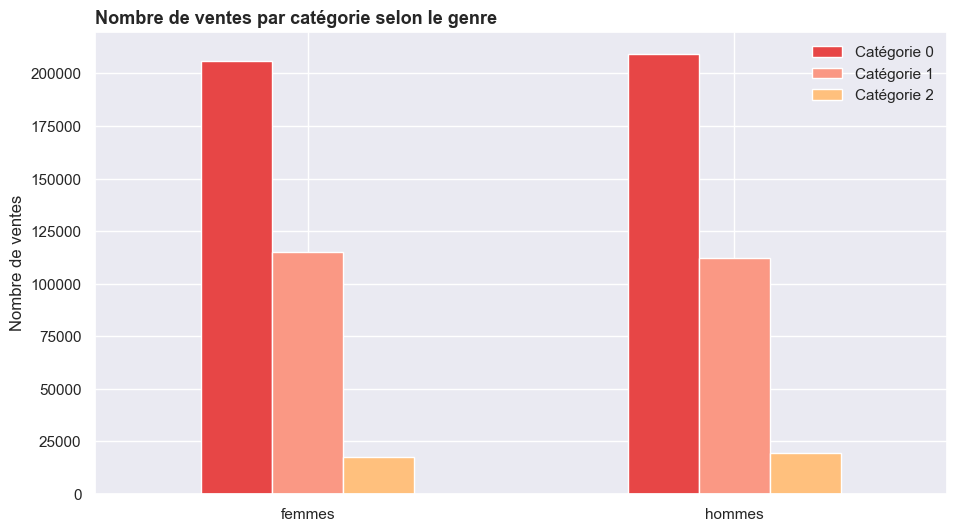

In [141]:
ax = df_genre.plot(kind="bar", ylabel="Nombre de ventes", width=0.5, figsize=(11,6), color=["#E74646", "#FA9884", "#FFC07D"])

ax.set(xlabel=None)

plt.title("Nombre de ventes par catégorie selon le genre", loc="left", fontsize=13, fontweight="bold")
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"], loc="upper right")

plt.xticks(rotation = 0)

plt.show()

Nous créons également une heatmap.

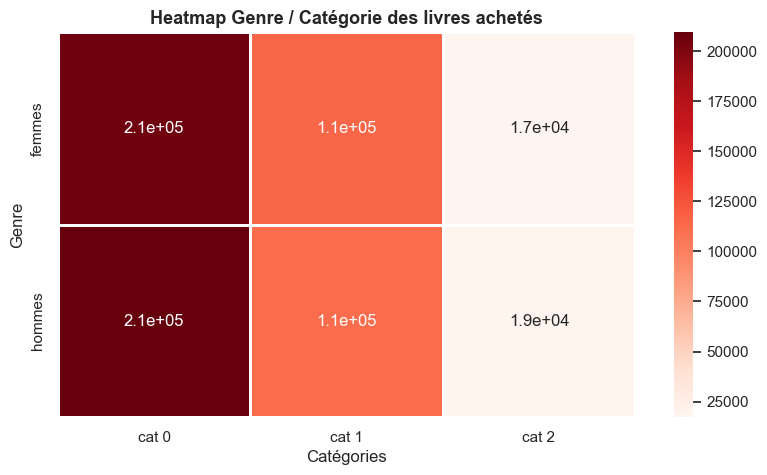

In [142]:
sb.heatmap(df_genre, linewidths=2, square=True, cmap='Reds', annot=True)

plt.title("Heatmap Genre / Catégorie des livres achetés", fontweight="bold", fontsize=13)
plt.ylabel("Genre")
plt.xlabel("Catégories")

plt.show()

### Tests statistique

1. Chi2

H0 : Les deux variables testées sont indépendantes.

In [143]:
resultats_test = stats.chi2_contingency(df_genre)

print("statistique de test :", round(resultats_test[0], 3))
print("p_valeur :", round(resultats_test[1], 3))
print("degré de liberté :", resultats_test[2])

statistique de test : 147.119
p_valeur : 0.0
degré de liberté : 2


La p-value est inférieur à 0.05.

On peut donc rejeter l’hypothèse selon laquelle les deux variables testées sont indépendantes.

Autrement dit, nous considérons donc qu'il existe un lien entre le genre et les catégories de livre achetés.

2. V de Cramer

In [144]:
X2 = resultats_test[0]
N = np.sum(df_genre)
minimum_dimension = min(df_genre.shape)-1

result = np.sqrt((X2/N) / minimum_dimension)
print(result)

categ
cat 0    0.018818
cat 1    0.025448
cat 2    0.063502
dtype: float64


Si la valeur est renvoyée est supérieure à 0.90, on peut qualifier la relation de très forte. 

Si la valeur est inférieure à 0.10, on peut qualifier la relation de faible.

Il semblerait que la catégorie 2 soit le plus corrélé et la catégorie 0 soit le moins corrélé.